# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.*

In this exercise, you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def rel_error(out, correct_out):
    return np.sum(abs(out - correct_out) / (abs(out) + abs(correct_out)))

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    Softmax, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # # We will also make a development set, which is a small subset of
    # the training set.
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [4]:
# Create one-hot vectors for label
num_class = 10
y_train_oh = np.zeros((y_train.shape[0], 10))
y_train_oh[np.arange(y_train.shape[0]), y_train] = 1
y_val_oh = np.zeros((y_val.shape[0], 10))
y_val_oh[np.arange(y_val.shape[0]), y_val] = 1
y_test_oh = np.zeros((y_test.shape[0], 10))
y_test_oh[np.arange(y_test.shape[0]), y_test] = 1

y_dev_oh = np.zeros((y_dev.shape[0], 10))
y_dev_oh[np.arange(y_dev.shape[0]), y_dev] = 1

# Regression as classifier
The most simple and straightforward approach to learn a classifier is to map the input data (raw image values) to class label (one-hot vector). The loss function is defined as following: 
$$\mathcal{L}=\frac{1}{n}\|\mathbf{X}\mathbf{W}-\mathbf{y}\|_F^2\qquad\qquad(1)$$
Where:
* $\mathbf{W}\in \mathbb{R}^{(d+1)\times C}$: Classifier weight
* $\mathbf{X}\in \mathbb{R}^{n\times (d+1)}$: Dataset
* $\mathbf{y}\in \mathbb{R}^{n\times C}$: Class label (one-hot vector)

# Optimization
Given the loss function (1), the next problem is how to solve the weight $\mathbf{W}$. We now discuss 2 approaches: 
 * Random search
 * Closed-form solution

## Random search

In [5]:
bestloss = float('inf')
for num in range(100):
    W = np.random.randn(3073, 10) * 0.0001
    loss = np.linalg.norm(X_dev.dot(W) - y_dev_oh)
    if (loss < bestloss):
        bestloss = loss
        bestW = W
    print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

in attempt 0 the loss was 31.097852, best 31.097852
in attempt 1 the loss was 35.986907, best 31.097852
in attempt 2 the loss was 32.936750, best 31.097852
in attempt 3 the loss was 32.263297, best 31.097852
in attempt 4 the loss was 33.316720, best 31.097852
in attempt 5 the loss was 33.530687, best 31.097852
in attempt 6 the loss was 33.089863, best 31.097852
in attempt 7 the loss was 33.797979, best 31.097852
in attempt 8 the loss was 31.849634, best 31.097852
in attempt 9 the loss was 31.078356, best 31.078356
in attempt 10 the loss was 32.901067, best 31.078356
in attempt 11 the loss was 32.724453, best 31.078356
in attempt 12 the loss was 34.693179, best 31.078356
in attempt 13 the loss was 33.269654, best 31.078356
in attempt 14 the loss was 33.896164, best 31.078356
in attempt 15 the loss was 31.727043, best 31.078356
in attempt 16 the loss was 31.291954, best 31.078356
in attempt 17 the loss was 34.024641, best 31.078356
in attempt 18 the loss was 31.856058, best 31.078356
in 

In [6]:
# How bestW perform:
print('Accuracy on train set: ', np.sum(np.argmin(np.abs(1 - X_dev.dot(bestW)), axis=1) == y_dev).astype(np.float32)/y_dev.shape[0]*100)
print('Accuracy on test set: ', np.sum(np.argmin(np.abs(1 - X_test.dot(bestW)), axis=1) == y_test).astype(np.float32)/y_test.shape[0]*100)

Accuracy on train set:  15.8
Accuracy on test set:  16.900000000000002


You can clearly see that the performance is very low, almost at the random level.

## Closed-form solution
The closed-form solution is achieved by:
$$\frac{\partial\mathcal{L}}{\partial \mathbf{W}}=\frac{2}{n}\mathbf{X}^T(\mathbf{X}\mathbf{W}-\mathbf{y})=0$$

$$\Leftrightarrow\mathbf{W}^\ast=(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

In [7]:
################################################################################
# TODO:                                                                        #
# Implement the closed-form solution of the weight W.                          #
################################################################################
X_train_trans = np.transpose(X_train)
pre = np.matmul(X_train_trans, X_train)
pre_inverse = np.linalg.inv(pre)
pre_pre = np.matmul(pre_inverse, X_train_trans)
W = np.matmul(pre_pre, y_train_oh)


 
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [8]:
# Check accuracy:
print('Train set accuracy: ', np.sum(np.argmin(np.abs(1 - X_train.dot(W)), axis=1) == y_train).astype(np.float32)/y_train.shape[0]*100)
print('Test set accuracy: ', np.sum(np.argmin(np.abs(1 - X_test.dot(W)), axis=1) == y_test).astype(np.float32)/y_test.shape[0]*100)

Train set accuracy:  51.163265306122454
Test set accuracy:  36.199999999999996


Now, you can see that the performance is much better.

## Regularization
A simple way to improve performance is to include the L2-regularization penalty.
$$\mathcal{L}=\frac{1}{n}\|\mathbf{X}\mathbf{W}-\mathbf{y}\|_F^2 +\lambda \|\mathbf{W}\|_F^2 \qquad\qquad(2)$$
The closed-form solution now is: 
$$\Leftrightarrow\mathbf{W}^\ast=(\mathbf{X}^T\mathbf{X}+\lambda n\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$

In [9]:
# try several values of lambda to see how it helps:
lambdas = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
train_acc = np.zeros((len(lambdas)))
test_acc = np.zeros((len(lambdas)))
for i in range(len(lambdas)):
    l = lambdas[i]
    n,d = X_train.shape[0], X_train.shape[1]
    ################################################################################
    # TODO:                                                                        #
    # Implement the closed-form solution of the weight W with regularization.      #
    ################################################################################
    X_train_trans = np.transpose(X_train)
    pre_1 = np.matmul(X_train_trans, X_train)
    pre = pre_1 + l * n * np.identity(pre_1.shape[0])
    pre_inverse = np.linalg.inv(pre)
    pre_pre = np.matmul(pre_inverse, X_train_trans)
    W = np.matmul(pre_pre, y_train_oh)
 
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################
    train_acc[i] = np.sum(np.argmin(np.abs(1 - X_train.dot(W)), axis=1) == y_train).astype(np.float32)/y_train.shape[0]*100
    print('Train set accuracy of ', l, ' : ', train_acc[i])
    test_acc[i]  = np.sum(np.argmin(np.abs(1 - X_te
                                           st.dot(W)), axis=1) == y_test).astype(np.float32)/y_test.shape[0]*100
    print('Test set accuracy of ', l, ' : ', test_acc[i])

Train set accuracy of  0.01  :  51.159183673469386
Test set accuracy of  0.01  :  36.3
Train set accuracy of  0.1  :  51.069387755102035
Test set accuracy of  0.1  :  36.3
Train set accuracy of  1  :  50.39591836734694
Test set accuracy of  1  :  37.1
Train set accuracy of  10  :  48.71632653061225
Test set accuracy of  10  :  37.8
Train set accuracy of  100  :  46.49183673469388
Test set accuracy of  100  :  39.2
Train set accuracy of  1000  :  44.304081632653066
Test set accuracy of  1000  :  40.5
Train set accuracy of  10000  :  41.55714285714286
Test set accuracy of  10000  :  40.2
Train set accuracy of  100000  :  37.30204081632653
Test set accuracy of  100000  :  38.1


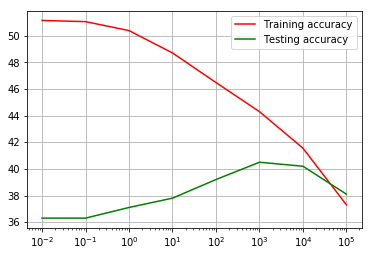

In [10]:
plt.semilogx(lambdas, train_acc, 'r', label="Training accuracy")
plt.semilogx(lambdas, test_acc, 'g', label="Testing accuracy")

plt.legend()
plt.grid(True)
plt.show()

**Question:** Try to explain why the performances on the training and test set have such behaviors as we change the value of $\lambda$.

**Your answer:** When $\lambda$ is small, W tends to be overfitting. When $\lambda$ is 1000, it has the most optimized result for testing set.

## Softmax Classifier

The predicted probability for the $j$-th class given a sample vector $x$ and a weight $W$ is:

$$\displaystyle{P(y=j\mid x)=\frac{e^{-xw_j}}{\sum\limits_{c=1}^{C}e^{-xw_c}}}$$ 

![softmax](imgs/softmax.png "Example of Softmax")

Your code for this section will all be written inside **classifiers/softmax.py**. 


In [14]:
# First implement the naive softmax loss function with nested loops.
# Open the file classifiers/softmax.py and implement the
# softmax_loss_naive function.

from classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.332788
sanity check: 2.302585


**Question:** Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Because we have in total 10 classes. So we compare our result with random guessing.

# Optimization


## Random search

In [15]:
bestloss = float('inf')
for num in range(100):
    W = np.random.randn(3073, 10) * 0.0001
    loss, _ = softmax_loss_naive(W, X_dev, y_dev, 0.0)
    if (loss < bestloss):
        bestloss = loss
        bestW = W
    print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

in attempt 0 the loss was 2.315287, best 2.315287
in attempt 1 the loss was 2.315728, best 2.315287
in attempt 2 the loss was 2.279245, best 2.279245
in attempt 3 the loss was 2.338965, best 2.279245
in attempt 4 the loss was 2.364009, best 2.279245
in attempt 5 the loss was 2.399972, best 2.279245
in attempt 6 the loss was 2.364766, best 2.279245
in attempt 7 the loss was 2.354514, best 2.279245
in attempt 8 the loss was 2.409205, best 2.279245
in attempt 9 the loss was 2.323656, best 2.279245
in attempt 10 the loss was 2.397302, best 2.279245
in attempt 11 the loss was 2.339812, best 2.279245
in attempt 12 the loss was 2.379946, best 2.279245
in attempt 13 the loss was 2.315949, best 2.279245
in attempt 14 the loss was 2.361623, best 2.279245
in attempt 15 the loss was 2.318217, best 2.279245
in attempt 16 the loss was 2.368780, best 2.279245
in attempt 17 the loss was 2.363134, best 2.279245
in attempt 18 the loss was 2.366291, best 2.279245
in attempt 19 the loss was 2.339898, best

In [16]:
# How bestW perform on trainset
scores = X_train.dot(bestW)
y_pred = np.argmax(scores, axis=1)
print('Accuracy on train set %f' % np.mean(y_pred == y_train))

# evaluate performance of test set
scores = X_test.dot(bestW)
y_pred = np.argmax(scores, axis=1)
print('Accuracy on test set %f' % np.mean(y_pred == y_test))

Accuracy on train set 0.131245
Accuracy on test set 0.124000


Compare the performance when using random search with *regression classifier* and *softmax classifier*. You can see how much useful the softmax classifier is.

## Stochastic Gradient descent
Even though it is possible to achieve closed-form solution with softmax classifier, it would be more complicated. In fact, we could achieve very good results with gradient descent approach. Additionally, in case of very large dataset, it is impossible to load the whole dataset into the memory. Gradient descent can help to optimize the loss function in batch. 

$$\mathbf{W}^{t+1}=\mathbf{W}^{t}−\alpha \frac{\partial\mathcal{L(\mathbf{x};\mathbf{W}^{t})}}{\partial\mathbf{W}^{t}}$$

Where $\alpha$ is the learning rate, $\mathcal{L}$ is a loss function, and $\mathbf{x}$ is a batch of training dataset.

In [17]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.863772 analytic: -0.863772, relative error: 3.286460e-08
numerical: -0.830557 analytic: -0.830557, relative error: 9.243450e-08
numerical: 2.159302 analytic: 2.159302, relative error: 3.404888e-08
numerical: -0.075499 analytic: -0.075499, relative error: 2.376996e-07
numerical: -5.666792 analytic: -5.666792, relative error: 2.276835e-09
numerical: -2.117591 analytic: -2.117591, relative error: 5.739073e-09
numerical: -0.995018 analytic: -0.995018, relative error: 1.605112e-08
numerical: 0.199430 analytic: 0.199430, relative error: 1.770890e-07
numerical: -0.060309 analytic: -0.060309, relative error: 9.127597e-08
numerical: -2.069928 analytic: -2.069928, relative error: 1.044419e-08
numerical: 0.176114 analytic: 0.176114, relative error: 2.150958e-07
numerical: -4.152779 analytic: -4.152779, relative error: 4.241791e-09
numerical: 0.782594 analytic: 0.782594, relative error: 1.654405e-08
numerical: 0.193260 analytic: 0.193260, relative error: 1.609427e-07
numerical: -2.68

In [24]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.355111e+00 computed in 11.699731s
vectorized loss: 8.587773e+00 computed in 0.009061s
Loss difference: 6.232662
Gradient difference: 141.386003


In [27]:
from classifiers.linear_classifier import *
# from classifiers import linear_classifier

classifier = Softmax()
tic = time.time()
loss_hist = classifier.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                                  num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 780.933791
iteration 100 / 1500: loss 781.235478
iteration 200 / 1500: loss 781.834763
iteration 300 / 1500: loss 784.080822
iteration 400 / 1500: loss 785.783550
iteration 500 / 1500: loss 788.199196
iteration 600 / 1500: loss 792.060046
iteration 700 / 1500: loss 795.235677
iteration 800 / 1500: loss 799.411085
iteration 900 / 1500: loss 804.025054
iteration 1000 / 1500: loss 808.421515
iteration 1100 / 1500: loss 815.391185
iteration 1200 / 1500: loss 820.561515
iteration 1300 / 1500: loss 828.572252
iteration 1400 / 1500: loss 834.540254
That took 4.650405s


In [28]:
# Write the Softmax.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.248061
validation accuracy: 0.263000


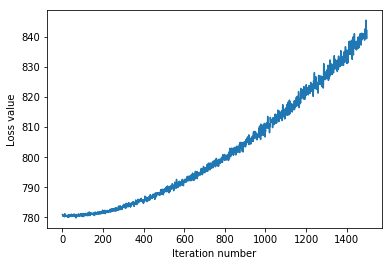

In [29]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [30]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = classifier.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %.2f' % (100*test_accuracy, ))

softmax on raw pixels final test set accuracy: 26.70


In [33]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 35% on the validation set.

import copy
best_val_acc = -1
best_softmax = None        # You may need to use copy.deepcopy(object)
learning_rates = [1e-4,1e-5, 1e-6,5e-7]
regularization_strengths = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
results = {}
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in best_softmax.                     #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        classifier = Softmax()
        classifier.train(X_train, y_train, learning_rate=lr, reg=rs,
                                  num_iters=1500, verbose=True)
        y_val_pred = classifier.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        if val_acc > best_val_acc:
            best_softmax = classifier
            best_val_acc = val_acc


################################################################################
#                              END OF YOUR CODE                                #
################################################################################   
print('best cross-validation accuracy: %.2f' % best_val_acc)

iteration 0 / 1500: loss 10.833682


/Users/lixingxuan/Desktop/Computer Vision/Week-01/forStudents/classifiers/softmax.py:90: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(correct))


iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 10.256135
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 11.253733
iteration 100 / 1500: loss inf
iteration 200 / 1500:

iteration 900 / 1500: loss 57.963793
iteration 1000 / 1500: loss 62.803546
iteration 1100 / 1500: loss 72.991386
iteration 1200 / 1500: loss 79.633485
iteration 1300 / 1500: loss 80.579326
iteration 1400 / 1500: loss 93.773303
iteration 0 / 1500: loss 10.588889
iteration 100 / 1500: loss 14.113477
iteration 200 / 1500: loss 16.690732
iteration 300 / 1500: loss 20.885429
iteration 400 / 1500: loss 27.943624
iteration 500 / 1500: loss 35.677015
iteration 600 / 1500: loss 41.977149
iteration 700 / 1500: loss 43.387496
iteration 800 / 1500: loss 56.239834
iteration 900 / 1500: loss 53.695806
iteration 1000 / 1500: loss 65.048353
iteration 1100 / 1500: loss 56.544349
iteration 1200 / 1500: loss 74.650788
iteration 1300 / 1500: loss 67.251700
iteration 1400 / 1500: loss 88.379485
iteration 0 / 1500: loss 9.969727
iteration 100 / 1500: loss 12.915702
iteration 200 / 1500: loss 16.621113
iteration 300 / 1500: loss 20.708916
iteration 400 / 1500: loss 25.566202
iteration 500 / 1500: loss 33.287

In [34]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %.2f' % (100*test_accuracy, ))

softmax on raw pixels final test set accuracy: 26.40
